# Load Data

In [ ]:

import os
import zipfile
import glob
from PIL import Image

from src.data.load_data_local import * 
from src.model.difussion_class import * 
from src.model.unet_backbone import *

from src.training_loops.main_train_loop import * 

from src.testing.ddpim_inference import * 
from src.testing.ddpm_inference import *

train_loader , dataloader = get_celeba_loader_from_zip(zip_path="img_align_celeba.zip")


Mounted at /content/drive
[OK] Imágenes detectadas (recursivo): 202599
[OK] DataLoader listo: batch_size=32, img_size=64


In [3]:

imgs, _ = next(iter(train_loader))
imgs.shape

torch.Size([32, 3, 64, 64])

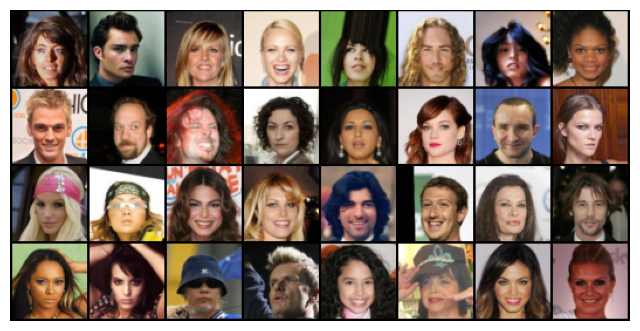

In [4]:

import matplotlib.pyplot as plt
import torchvision

imgs, _ = next(iter(train_loader))
imgs = (imgs * 0.5) + 0.5
grid = torchvision.utils.make_grid(imgs[:64], nrow=8)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [15]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [ ]:
from torch.optim import AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"

model_low_gpu = model = build_unet_64x64(base_channels=96, channel_mults=(1, 2, 2, 2), num_res_blocks=1, attn_resolutions={8},  num_heads=2, head_dim=32, dropout=0.1).to(device)

diffusion = Diffusion(T=1000, schedule="linear", beta_min=1e-4, beta_max=2e-2 , img_size=64).to(device)
ema = EMA(model_low_gpu, decay=0.9995, device=device)

optimizer = AdamW(model_low_gpu.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=0.0)
scaler = None


In [ ]:
torch.backends.cudnn.benchmark = True

train_ddpm(
    model=model_low_gpu, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=10, base_lr=2e-4, warmup_steps=1000,
    grad_clip=1.0, use_autocast=True, scaler=None, 
    sample_every=2, sample_n=16, img_size=64,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba64_ddpm_lowgpu",
    save_every=4, save_last=True, resume_path=None, ckpt_utils=(save_ckpt, load_ckpt),
    grad_accum_steps=1, use_channels_last=True, on_oom="skip",

    # DIAG:
    log_every=400,                  # imprime cada 200 steps efectivos
    probe_timesteps=[10, 50, 200, 500],
    log_mem=True,                   # memoria GPU asignada/reservada
    log_grad_norm=True,             # ||grad||
    sample_seed=1234,               # grids comparables entre épocas
    sample_steps=None               # (para DDIM/fast-sampling más adelante)
)


────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba64_ddpm_lowgpu
Device: cuda | autocast: True | EMA: 0.999500 | epochs: 10 | base_lr: 2.00e-04 | warmup_steps: 1000
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆   (baseline)  ε-MSE ≈ 0.996  (esperado ~1.0)
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆        400 |  8.00e-05 |   0.0453 |   7777.3 |   1.79e-01 | mem=759/1978MB | t=10:0.476 t=50:0.181 t=200:0.060 t=500:0.027
┆        800 |  1.60e-04 |   0.0166 |    204.3 |   2.65e-01 | mem=759/4054MB | t=10:0.358 t=50:0.140 t=200:0.042 t=500:0.014
┆       1200 |  2.00e-04 |   0

In [ ]:
resume_path = "/content/checkpoints/celeba64_ddpm_lowgpu_last.pt"

train_ddpm(
    model=model_low_gpu, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=15,                      # total = 10 previas + 15 nuevas
    base_lr=2e-4, warmup_steps=1000,
    grad_clip=1.0, use_autocast=True, scaler=None,  
    sample_every=2, sample_n=16, img_size=64,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba64_ddpm_lowgpu",
    save_every=4, save_last=True,
    resume_path=resume_path, ckpt_utils=(save_ckpt, load_ckpt),  # <IMPORTANTE
    grad_accum_steps=1, use_channels_last=True, on_oom="skip",

    # DIAG:
    log_every=400,
    probe_timesteps=[10, 50, 200, 500],
    log_mem=True,
    log_grad_norm=True,
    sample_seed=1234,
    sample_steps=None
)

[RESUME] Cargado: /content/checkpoints/celeba64_ddpm_lowgpu_last.pt | global_step=31250 | start_epoch=10
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba64_ddpm_lowgpu
Device: cuda | autocast: True | EMA: 0.999500 | epochs: 15 | base_lr: 2.00e-04 | warmup_steps: 1000
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆      31600 |  2.00e-04 |   0.0176 |    211.1 |   9.34e-02 | mem=895/4180MB | t=10:0.190 t=50:0.069 t=200:0.021 t=500:0.004
┆      32000 |  2.00e-04 |   0.0332 |    208.5 |   1.21e-01 | mem=895/4180MB | t=10:0.205 t=50:0.

In [ ]:
resume_path = "/content/checkpoints/celeba64_ddpm_lowgpu_last.pt"

train_ddpm(
    model=model_low_gpu, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=30,                    
    base_lr=2e-4, warmup_steps=1000,
    grad_clip=1.0, use_autocast=True, scaler=None,      
    sample_every=2, sample_n=16, img_size=64,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba64_ddpm_lowgpu",
    save_every=4, save_last=True,
    resume_path=resume_path, ckpt_utils=(save_ckpt, load_ckpt),
    grad_accum_steps=1, use_channels_last=True, on_oom="skip",

    # DIAG:
    log_every=400,
    probe_timesteps=[10, 50, 200, 500],
    log_mem=True,
    log_grad_norm=True,
    sample_seed=1234,
    sample_steps=None
)

[RESUME] Cargado: /content/checkpoints/celeba64_ddpm_lowgpu_last.pt | global_step=46875 | start_epoch=15
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba64_ddpm_lowgpu
Device: cuda | autocast: True | EMA: 0.999500 | epochs: 30 | base_lr: 2.00e-04 | warmup_steps: 1000
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆      47200 |  2.00e-04 |   0.0136 |    212.6 |   9.17e-02 | mem=895/4220MB | t=10:0.211 t=50:0.077 t=200:0.023 t=500:0.005
┆      47600 |  2.00e-04 |   0.0143 |    208.6 |   2.26e-02 | mem=895/4220MB | t=10:0.196 t=50:0.

In [ ]:
resume_path = "/content/celeba64_ddpm_lowgpu_last_30.pt"

train_ddpm(
    model=model_low_gpu, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=55,                     
    base_lr=2e-4, warmup_steps=1000,
    grad_clip=1.0, use_autocast=True, scaler=None,      
    sample_every=2, sample_n=16, img_size=64,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba64_ddpm_lowgpu",
    save_every=8, save_last=True,
    resume_path=resume_path, ckpt_utils=(save_ckpt, load_ckpt),  
    grad_accum_steps=1, use_channels_last=True, on_oom="skip",

    # DIAG:
    log_every=400,
    probe_timesteps=[10, 50, 200, 500],
    log_mem=True,
    log_grad_norm=True,
    sample_seed=1234,
    sample_steps=None)



[RESUME] Cargado: /content/celeba64_ddpm_lowgpu_last_30.pt | global_step=93750 | start_epoch=30
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba64_ddpm_lowgpu
Device: cuda | autocast: True | EMA: 0.999500 | epochs: 55 | base_lr: 2.00e-04 | warmup_steps: 1000
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆      94000 |  2.00e-04 |   0.0079 |    252.8 |   4.93e-02 | mem=200/3370MB | t=10:0.213 t=50:0.082 t=200:0.025 t=500:0.005
┆      94400 |  2.00e-04 |   0.0118 |    210.3 |   1.72e-01 | mem=200/3370MB | t=10:0.203 t=50:0.076 t=200

# Testing

---

In [ ]:

_ = ddpm_infer_sample(
    model=model_low_gpu,
    diffusion=diffusion,
    n=36,
    img_size=64,
    device=device,
    ema=ema,
    out_path="checkpoints/celeba64_samples_e2.png",
    save_individual=False,
    out_dir="checkpoints/celeba64_samples_e0_indiv" , seed=7)

[INFER] Grid guardado en: checkpoints/celeba64_samples_e2.png


In [ ]:

_ = ddim_infer_sample(
    model_low_gpu, diffusion,
    n=36, img_size=64, device=device,
    ema=ema,
    out_path="checkpoints/celeba64_ddim50.png",
    seed=7,
    steps=50, eta=0.0,             # 50 pasos, determinista
    schedule_kind="linear",
    save_individual=False
)

[INFER-DDIM] Grid guardado en: checkpoints/celeba64_ddim50.png  (steps=50, eta=0.0)


---

In [ ]:
_ = render_denoise_strip(
    model=model_low_gpu, diffusion=diffusion,
    img_size=64, device=device, ema=ema, seed=1234,
    out_path="checkpoints/celeba64_denoise_strip_e00.png",
    capture_steps=None  # o lista explícita, p.ej. [999,800,600,400,300,200,150,100,80,60,40,20,10,5,0]
)

In [22]:
_ = render_denoise_strip(
    model=model_low_gpu, diffusion=diffusion,
    img_size=64, device=device, ema=ema, seed=1,
    out_path="checkpoints/celeba64_denoise_strip_e02.png",
    capture_steps= [999,600,300,200,100,80,40,10,5,0])

[DENOISE] strip 1×10 guardado → checkpoints/celeba64_denoise_strip_e02.png


---

In [38]:
sched = sorted(set(torch.round(torch.linspace(diffusion.T-1, 0, 50)).long().tolist()), reverse=True)
idxs  = [0, 5, 10, 15, 20, 25, 30, 35, 40, -1]
caps  = [sched[i] for i in idxs]

_ = render_denoise_strip_ddim(
    model=model_low_gpu,
    diffusion=diffusion,
    img_size=64,
    device=device,
    ema=ema,
    seed=7,
    out_path="checkpoints/celeba64_denoise_strip_ddim.png",
    capture_steps=caps,
    pad=2,
    steps=50,
    eta=0.0,
    schedule_kind="linear")

[DENOISE-DDIM] strip 1×10 guardado → checkpoints/celeba64_denoise_strip_ddim.png (steps=50, eta=0.0)
